In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('train.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [3]:
df.head()
# separe numerical and categorical variables
df_num = df.select_dtypes(include = 'number')
df_cat = df.select_dtypes(include = 'object')
df_cat = df_cat.drop(['LoanID'], axis = 1)
df_cat.head()

# check unique values of categorical variables before encoding
for column in df_cat.columns:
    print(column)
    print(df_cat[column].unique())

df_cat_hot = df_cat[['HasMortgage','HasDependents','HasCoSigner']]
df_cat_label = df_cat.drop(df_cat_hot.columns, axis = 1)
df_cat_label

Education
["Bachelor's" "Master's" 'High School' 'PhD']
EmploymentType
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
MaritalStatus
['Divorced' 'Married' 'Single']
HasMortgage
['Yes' 'No']
HasDependents
['Yes' 'No']
LoanPurpose
['Other' 'Auto' 'Business' 'Home' 'Education']
HasCoSigner
['Yes' 'No']


,Education,EmploymentType,MaritalStatus,LoanPurpose
0,Bachelor's,Full-time,Divorced,Other
1,Master's,Full-time,Married,Other
2,Master's,Unemployed,Divorced,Auto
3,High School,Full-time,Married,Business
4,Bachelor's,Unemployed,Divorced,Auto
...,...,...,...,...
255342,Bachelor's,Full-time,Married,Other
255343,High School,Part-time,Divorced,Home
255344,High School,Self-employed,Married,Auto
255345,High School,Part-time,Single,Other


### Label encoding

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in df_cat_label.columns:
    df_cat_label[f'{column}_encoded'] = le.fit_transform(df_cat_label[column])
    df_cat_label = df_cat_label.drop([column], axis = 1)

df_cat_label.head()

,Education_encoded,EmploymentType_encoded,MaritalStatus_encoded,LoanPurpose_encoded
0,0,0,0,4
1,2,0,1,4
2,2,3,0,0
3,1,0,1,1
4,0,3,0,0


#### One-Hot Encoding


In [5]:
df_cat_hot = pd.get_dummies(df_cat_hot, columns = df_cat_hot.columns, drop_first = True)
df_cat_hot.head()

df_cat = pd.concat([df_cat_label,df_cat_hot], axis = 1)
df_cat.head()

df_final = pd.concat([df_cat,df_num], axis = 1)
df_final.head()


,Education_encoded,EmploymentType_encoded,MaritalStatus_encoded,LoanPurpose_encoded,HasMortgage_Yes,HasDependents_Yes,HasCoSigner_Yes,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,0,0,0,4,True,True,True,56,85994,50587,520,80,4,15.23,36,0.44,0
1,2,0,1,4,False,False,True,69,50432,124440,458,15,1,4.81,60,0.68,0
2,2,3,0,0,True,True,False,46,84208,129188,451,26,3,21.17,24,0.31,1
3,1,0,1,1,False,False,False,32,31713,44799,743,0,3,7.07,24,0.23,0
4,0,3,0,0,False,True,False,60,20437,9139,633,8,4,6.51,48,0.73,0


In [6]:

X = df_final.drop('Default', axis = 1)
y = df_final['Default']

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func = mutual_info_classif, k = 'all')
X_new_all = selector.fit_transform(X,y)

In [8]:
mask = selector.get_support()

In [9]:
selected_columns = X.columns[mask]

In [10]:
print("Selected columns")
print(selected_columns)

Selected columns
Index(['Education_encoded', 'EmploymentType_encoded', 'MaritalStatus_encoded',
       'LoanPurpose_encoded', 'HasMortgage_Yes', 'HasDependents_Yes',
       'HasCoSigner_Yes', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio'],
      dtype='object')


In [11]:
X_selected_df = pd.DataFrame(X_new_all, columns = selected_columns)


In [12]:

'''
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build TensorFlow model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)




import pickle

with open('tensor_all','wb') as f :
    pickle.dump(history, f)
    
'''

'\n# Scale features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X_selected_df)\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# Build TensorFlow model\nmodel = Sequential()\nmodel.add(Dense(64, input_dim=X_train.shape[1], activation=\'relu\'))\nmodel.add(Dense(32, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'sigmoid\'))  # Binary classification\n\n# Compile model\nmodel.compile(optimizer=\'adam\',\n              loss=\'binary_crossentropy\',\n              metrics=[\'accuracy\', tf.keras.metrics.AUC(name=\'auc\')])\n\n# Train model\nhistory = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)\n\n# Evaluate model\nloss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)\nprint(f"Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")\n\n\nimport pickle\n\nwith open(\'tensor_all\',\'wb\') as f :\n    pickle.dump(history, f)\n    \n'

In [13]:
with open('tensor_all', 'rb') as f:
    tensor_all = pickle.load(f)

In [14]:
import matplotlib.pyplot as plt

def build_tf_plt(model):
    
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Train Acc')
    plt.plot(model.history['val_accuracy'], label='Val Acc')
    plt.title('Tensor Flow Model Accuracy with all variables')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(model.history['auc'], label='Train AUC')
    plt.plot(model.history['val_auc'], label='Val AUC')
    plt.title('Tensor Flow Model AUC with all variables')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [15]:
# building a def for making data frame of kbest with size of columns

def selectkbest_n(df, target, score_f, n):
    '''
    Build a data frame selected by Kbest
    
    Argument
        df (Data Frame) explored and selected columns chosen by kbest from
        target (str) column name of target value
        score_f (str) name of score to use (f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression)
        n (int) number of columns to pick

    Return
        df_new (Data Frame) builten data frame with SelectKBest
    '''
    X = df.drop(target, axis = 1)
    y = df[target]
    selector = SelectKBest(score_func = score_f, k = n)
    X_new = selector.fit_transform(X,y)
    mask = selector.get_support()
    selected_col = X.columns[mask]
    print("Selected columns")
    print(selected_col)
    df_new = pd.DataFrame(X_new, columns = selected_col)
   
    return df_new
df_final

,Education_encoded,EmploymentType_encoded,MaritalStatus_encoded,LoanPurpose_encoded,HasMortgage_Yes,HasDependents_Yes,HasCoSigner_Yes,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,0,0,0,4,True,True,True,56,85994,50587,520,80,4,15.23,36,0.44,0
1,2,0,1,4,False,False,True,69,50432,124440,458,15,1,4.81,60,0.68,0
2,2,3,0,0,True,True,False,46,84208,129188,451,26,3,21.17,24,0.31,1
3,1,0,1,1,False,False,False,32,31713,44799,743,0,3,7.07,24,0.23,0
4,0,3,0,0,False,True,False,60,20437,9139,633,8,4,6.51,48,0.73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,0,0,1,4,False,False,False,19,37979,210682,541,109,4,14.11,12,0.85,0
255343,1,1,0,3,False,False,False,32,51953,189899,511,14,2,11.55,24,0.21,1
255344,1,2,1,0,True,True,True,56,84820,208294,597,70,3,5.29,60,0.50,0
255345,1,1,2,4,True,True,False,42,85109,60575,809,40,1,20.90,48,0.44,0


In [16]:
# make a new data frame selected 10 columns by kbest selection
df_kbest_10 = selectkbest_n(df_final, 'Default', mutual_info_classif, 10)
df_kbest_10.head()

Selected columns
Index(['Education_encoded', 'EmploymentType_encoded', 'MaritalStatus_encoded',
       'LoanPurpose_encoded', 'HasMortgage_Yes', 'HasDependents_Yes',
       'HasCoSigner_Yes', 'Age', 'NumCreditLines', 'LoanTerm'],
      dtype='object')


,Education_encoded,EmploymentType_encoded,MaritalStatus_encoded,LoanPurpose_encoded,HasMortgage_Yes,HasDependents_Yes,HasCoSigner_Yes,Age,NumCreditLines,LoanTerm
0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,56.0,4.0,36.0
1,2.0,0.0,1.0,4.0,0.0,0.0,1.0,69.0,1.0,60.0
2,2.0,3.0,0.0,0.0,1.0,1.0,0.0,46.0,3.0,24.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,32.0,3.0,24.0
4,0.0,3.0,0.0,0.0,0.0,1.0,0.0,60.0,4.0,48.0


In [17]:

def tf_build(df):
    '''
    train tensor flow model with 20 epoch and 32 batch size, split 0.2 and verbose 1
    Argument
        df (data frame) dataset to train
    return
        history (Model) trained model

    '''
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Build TensorFlow model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    # Train model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
    
    # Evaluate model
    loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    
    return history



In [18]:
'''
model = tf_build(df_kbest_10)

with open('tf_kbest_10','wb') as f:
    pickle.dump(model,f)

'''

"\nmodel = tf_build(df_kbest_10)\n\nwith open('tf_kbest_10','wb') as f:\n    pickle.dump(model,f)\n\n"

In [19]:
with open('tf_kbest_10','rb') as f:
    tf_kbest_10 = pickle.load(f)

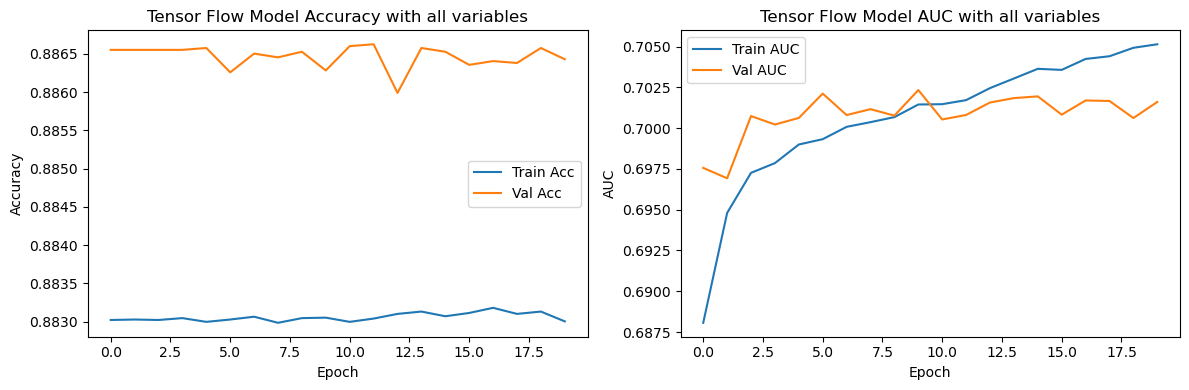

In [21]:
build_tf_plt(tf_kbest_10)

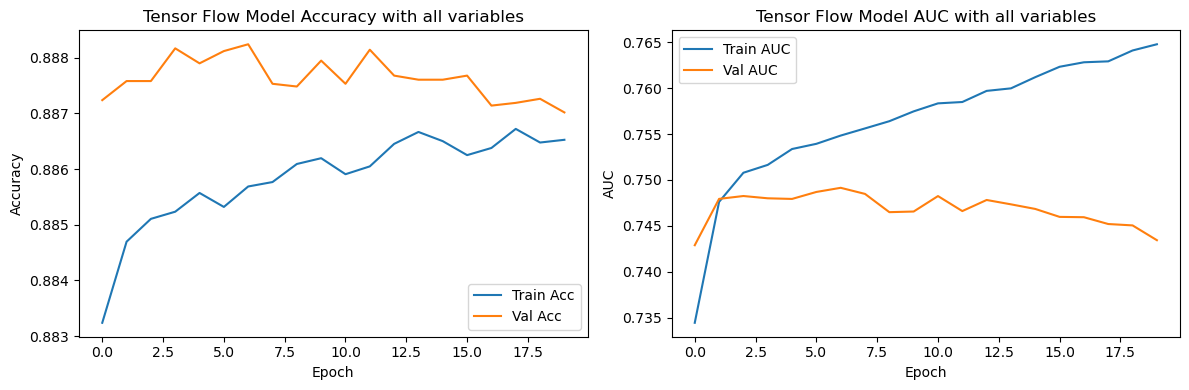

In [23]:
build_tf_plt(tensor_all)

In [24]:

def eval_tf_model(model) :
    loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    


AttributeError: 'History' object has no attribute 'dtype'